# Drawing Graphs


This notebook shows how to use `PyMDE` to layout graphs, using simple MDE problems.

In [1]:
import pymde

import numpy as np
import scipy.sparse as sp
import torch

## Creating a graph

The `PyMDE.Graph` class encapsulates an undirected weighted graph. 

Graphs have three parts: nodes, edges, and weights.

- *Nodes* are represented by non-negative integers; a graph on $n$ nodes will have nodes $0, 1, 2, \ldots, n - 1$.

- An *edge* is an array `e` of two node indices, with `e[0] < e[1]`. 

- Each edge has an associated scalar number, which can be interpreted as a *weight* on the edge or a distance between the nodes it connects. 

Graphs can be constructed from adjacency matrices or adjacency lists.
- An *adjacency matrix* is a sparse matrix `A` of shape `(n, n)`, with `A[i, j]` giving the weight associated with edge $(i, j)$. If `A[i, j]` is `0`, then edge $(i, j)$ is not present in the grpah.
- An *adjacency list* is an array of edges, with each row corresponding to an edge. 

Here is a simple example that show how to create graphs.

tensor([[-0.2056, -0.5395],
        [ 0.5700,  0.0917],
        [-0.3644,  0.4478]])

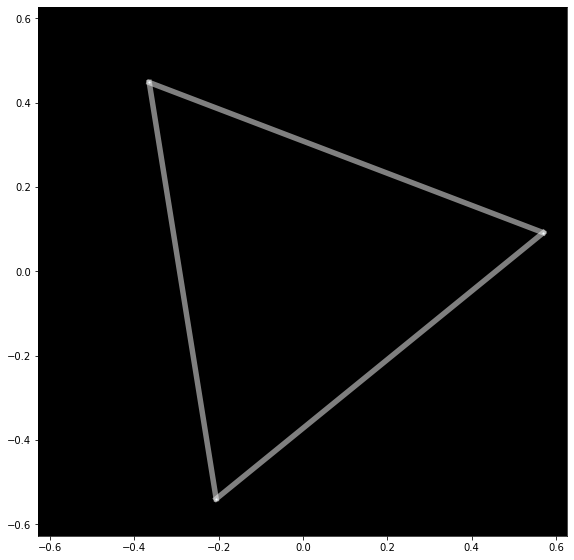

In [2]:
adjacency_matrix = sp.csr_matrix(np.array([
   [0, 1, 1],
   [1, 0, 1],
   [1, 1, 0],
]))
triangle = pymde.Graph(adjacency_matrix)
triangle.draw()

tensor([[-0.5771,  0.0186],
        [ 0.2724, -0.5090],
        [ 0.3046,  0.4904]])

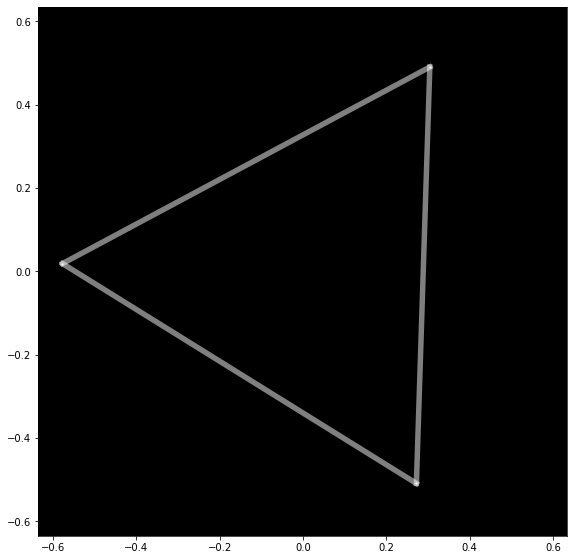

In [3]:
edges = torch.tensor([
   [0, 1],
   [0, 2],
   [1, 2]
])
triangle = pymde.Graph.from_edges(edges)
triangle.draw()

## Drawing graphs

The `draw` method lays out the graph in the Cartesian plane. Behind-the-scenes, it constructs and solves
MDE problems that are suitable for laying out graphs.


We used this method in the previous cells. In the remainder of this notebook, we show how to draw graphs by 
creating and solving MDE problems from scratch.

In [4]:
n_items = 20
embedding_dim = 2

### Complete Graph

<AxesSubplot:>

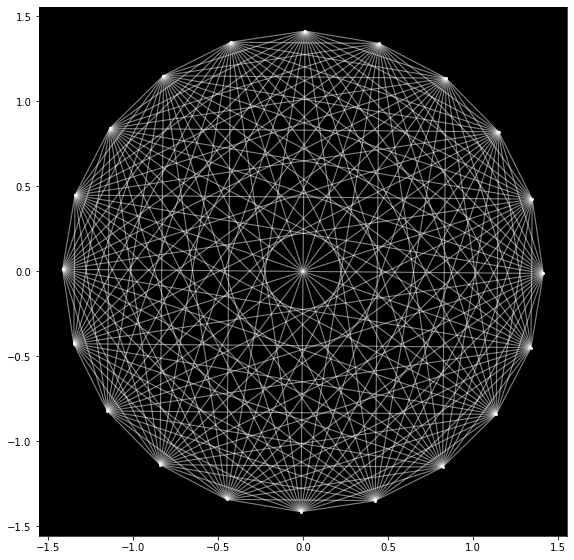

In [5]:
edges = pymde.all_edges(n_items)
mde = pymde.MDE(
    n_items,
    embedding_dim=embedding_dim,
    edges=edges,
    distortion_function=pymde.penalties.Cubic(weights=1.0),
    constraint=pymde.Standardized())
mde.embed()
mde.plot(edges=edges)

### Chain Graph

<AxesSubplot:>

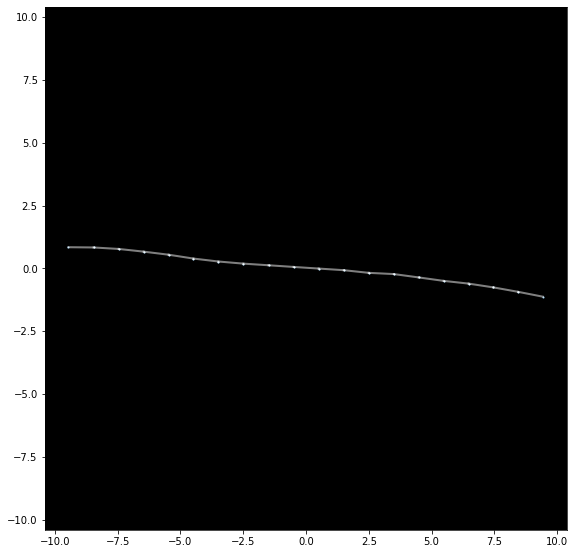

In [6]:
chain_graph = pymde.Graph.from_edges(torch.tensor([(i, i+1) for i in range(n_items-1)]))
shortest_paths_graph = pymde.preprocess.graph.shortest_paths(chain_graph)

mde = pymde.MDE(
    n_items,
    embedding_dim,
    shortest_paths_graph.edges,
    pymde.losses.WeightedQuadratic(deviations=shortest_paths_graph.distances))
mde.embed()
mde.plot(edges=chain_graph.edges)

### Cycle Graph

<AxesSubplot:>

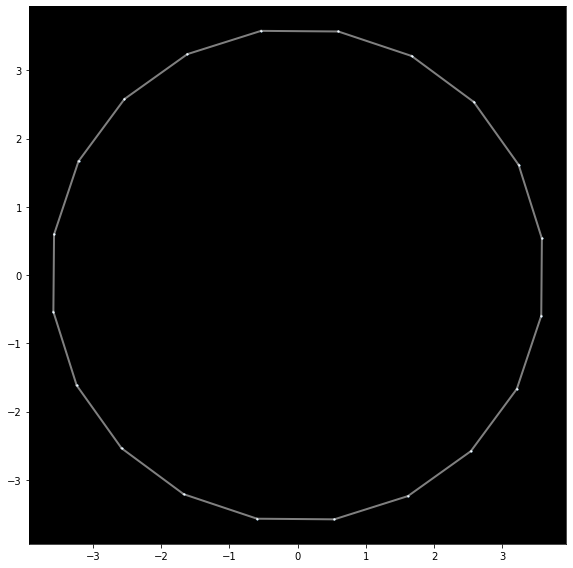

In [7]:
cycle_graph = pymde.Graph.from_edges(torch.tensor([(i, i+1) for i in range(n_items-1)] + [(n_items-1, 0)]))
shortest_paths_graph = pymde.preprocess.graph.shortest_paths(cycle_graph)

mde = pymde.MDE(
    n_items,
    embedding_dim,
    shortest_paths_graph.edges,
    pymde.losses.WeightedQuadratic(shortest_paths_graph.distances))
mde.embed()
mde.plot(edges=cycle_graph.edges)

### Star Graph

<AxesSubplot:>

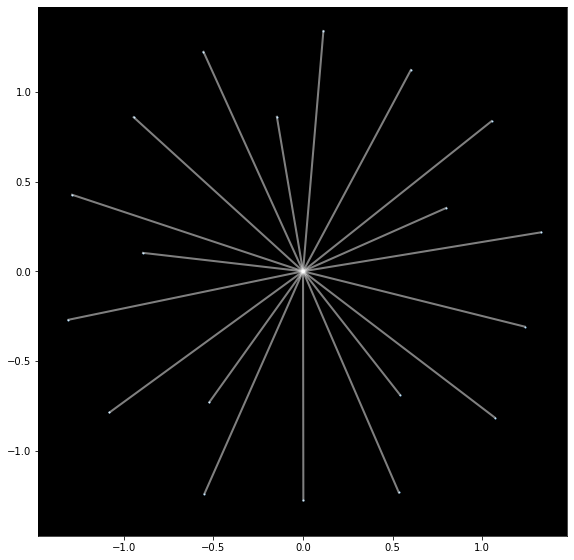

In [8]:
star_graph = pymde.Graph.from_edges(torch.tensor([(0, i) for i in range(1, n_items)]))
shortest_paths_graph = pymde.preprocess.graph.shortest_paths(star_graph)

mde = pymde.MDE(
    n_items,
    embedding_dim,
    shortest_paths_graph.edges,
    pymde.losses.WeightedQuadratic(shortest_paths_graph.distances))
mde.embed()
mde.plot(edges=star_graph.edges)

### Tree 

<AxesSubplot:>

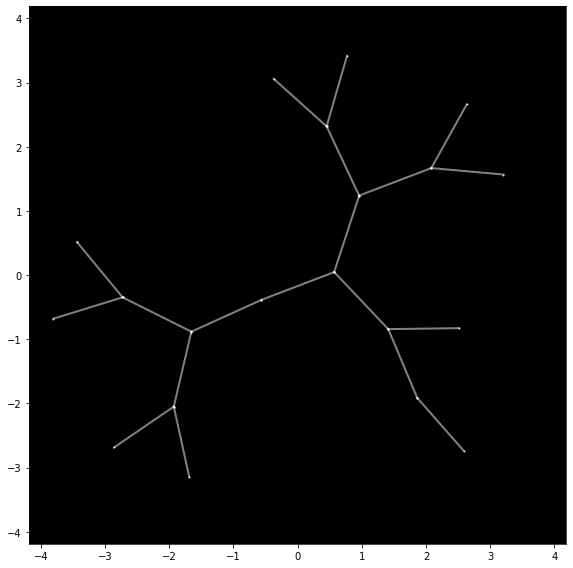

In [9]:
edges = []
stack = [0]
while stack:
    root = stack.pop()
    c1 = root*2 + 1
    c2 = root*2 + 2
    if c1 < n_items:
        edges.append((root, c1))
        stack.append(c1)
    if c2 < n_items:
        edges.append((root, c2))
        stack.append(c2)
tree = pymde.Graph.from_edges(torch.tensor(edges))
shortest_paths_graph = pymde.preprocess.graph.shortest_paths(tree)

mde = pymde.MDE(
    n_items,
    embedding_dim,
    shortest_paths_graph.edges,
    pymde.losses.WeightedQuadratic(shortest_paths_graph.distances))
mde.embed(snapshot_every=1, max_iter=20)
mde.plot(edges=tree.edges)

The `play` method creates a movie showing how the embedding was made. Try it out!

  0%|          | 0/21 [00:00<?, ?it/s]

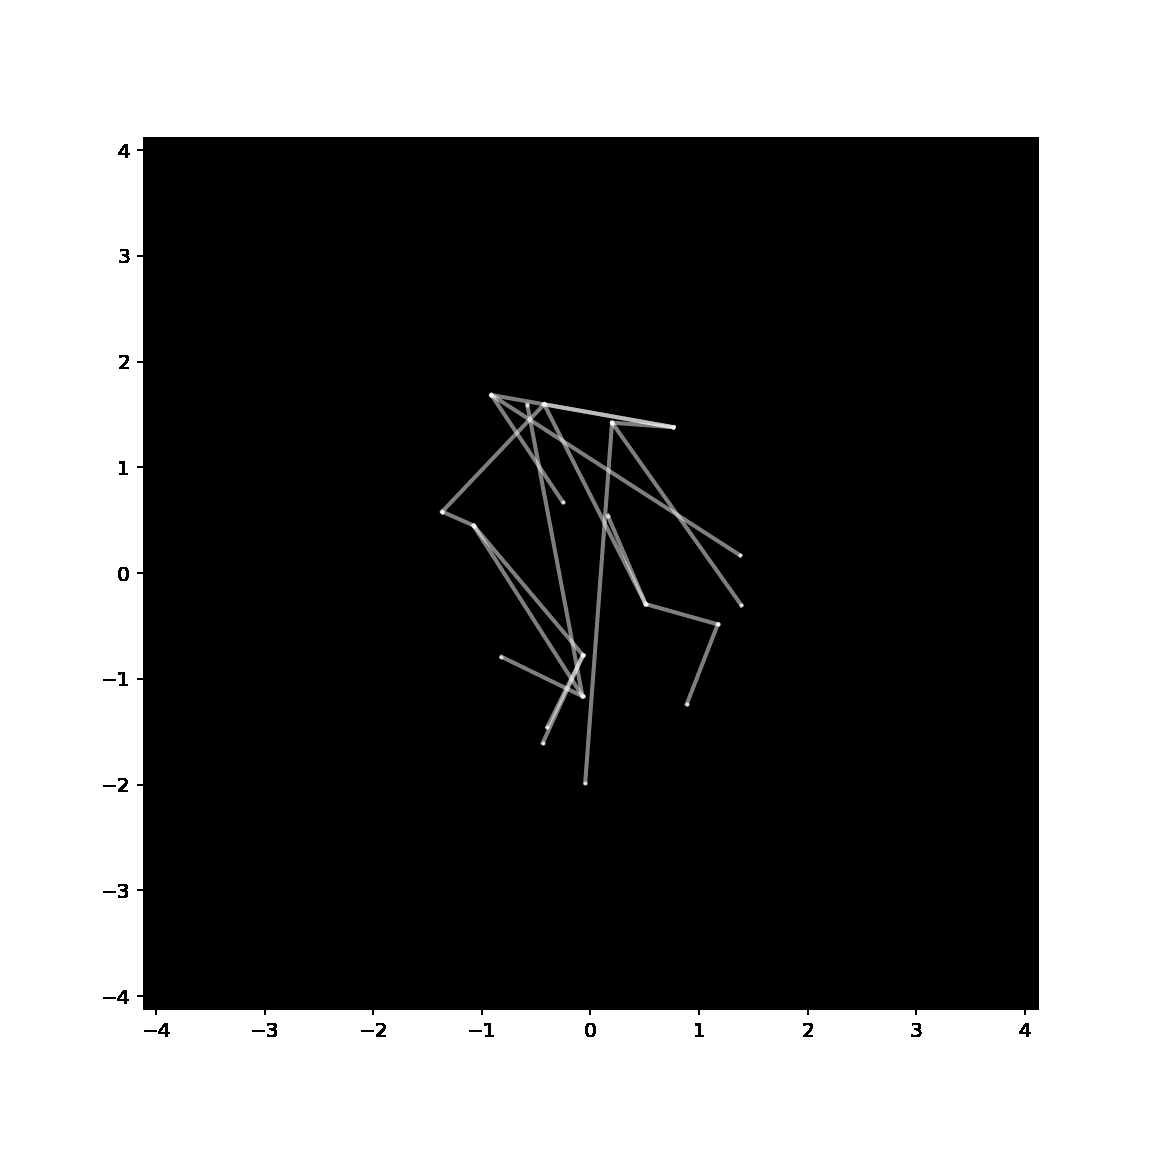

In [10]:
mde.play(edges=tree.edges, fps=15.)